In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# 1. Introduction

General condition: The stock price is above its 200-day moving average.

* Buy decision if:
    * 10-period RSI of the stock is below 30. 
    * Buy on the next day's open.

* Sell decision if:
    * 10-period RSI is above 40 OR after 10 trading days. 

The universe of stocks testing this strategy: All 505 single S&P stocks. 
In this project I'll also test it in IBOVESPA stocks.

RSI Calculation: 

* Step 1: Calculating Up and Down Moves
    * Upmoves: 
      * Take the daily return if return is positive. 
      * Take 0 if daily return is negative or zero
     
    * Downmoves:
      * Absolute value of daily return if return is negative
      * Zero if return is positive or zero.

* Step 2: Averaging Up and Downmoves
  Pick an average method
  -e.g. Simple moving average, exponential moving average.

  We will take Wilder's smoothing average method which is the same as an exponential moving average but with a different smoothing factor.
  Smoothing factor in exponential moving average is: alpha = 2/(N+1) where N = number of days.
  Smoothing factor in WSM is: alpha = 1/N

  As there is no WSM function in Python to get the WSM alpha of 1/10 we would have to use a N of 19 in the exponential moving average formula.

* Step 3: RS and RSI calculation
  RS - Average Upmove / Average Downmove
  RSI - 100 - 100/(1+RS)  

In [5]:
#Obtendo cotacoes
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers.Symbol.to_list()
tickers = [i.replace('.','-') for i in tickers] #fixing the tickers with dots.

In [6]:
tickers.pop(474)
tickers.pop(489)

'WY'

In [27]:
def RSIcalc(asset):
    dataset = yf.download(asset, start='2011-01-01')
    dataset['MA200'] = dataset['Adj Close'].rolling(window=200).mean() 
    dataset['price change'] = dataset['Adj Close'].pct_change()
    dataset['Upmove'] = dataset['price change'].apply(lambda x: x if x > 0 else 0)
    dataset['Downmove'] = dataset['price change'].apply(lambda x: abs(x) if x < 0 else 0)
    dataset['avg_Up'] = dataset['Upmove'].ewm(span=19).mean()
    dataset['avg_Down'] = dataset['Downmove'].ewm(span=19).mean()
    dataset = dataset.dropna()
    dataset['RS'] = dataset['avg_Up']/dataset['avg_Down']
    dataset['RSI'] = dataset['RS'].apply(lambda x: 100 - (100/(x + 1)))
    dataset.loc[(dataset['Adj Close'] > dataset['MA200']) & (dataset['RSI'] < 30), 'Buy'] = 'Yes'
    dataset.loc[(dataset['Adj Close'] < dataset['MA200']) | (dataset['RSI'] > 30), 'Buy'] = 'No'

    return dataset    

In [45]:
def getSignals(df):
    buying_dates = []
    selling_dates = []
    for i in range(len(df) - 11): #we need to put this -11 because we would out of this range when interating with j and add 1 in the selling_dates.append(df.iloc[i+j+1].name)
        if df['Buy'].iloc[i] == "Yes":
            buying_dates.append(df.iloc[i+1].name) #name is the timestamp. If I get a Yes, we wanna buy the next day.
            #Checking the selling days its more tricky. 
            #Selling points will be as stablished before when rsi exceed 40 points in the next 10 days.
            for j in range(1,11):
                if df.RSI.iloc[i+j] > 40:
                    selling_dates.append(df.iloc[i+j+1].name)
                    break
                elif j==10:
                    selling_dates.append(df.iloc[i+j+1].name)
    return buying_dates, selling_dates

In [32]:
frame = RSIcalc(tickers[0])
buy, sell = getSignals(frame)
frame[frame.Buy == "Yes"].head(2).round(2)

[*********************100%%**********************]  1 of 1 completed
C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_28860\1986622364.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['RS'] = dataset['avg_Up']/dataset['avg_Down']
C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_28860\1986622364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['RSI'] = dataset['RS'].apply(lambda x: 100 - (100/(x + 1)))
C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_28860\1986622364.py:12: SettingWithCopyW

,Open,High,Low,Close,Adj Close,Volume,MA200,price change,Upmove,Downmove,avg_Up,avg_Down,RS,RSI,Buy
Date,,,,,,,,,,,,,,,
2012-03-06,85.72,85.86,84.83,84.95,57.77,3547900,56.52,-0.02,0.0,0.02,0.0,0.00,0.33,24.64,Yes
2012-04-10,86.19,86.40,84.44,84.58,57.52,3651000,56.36,-0.02,0.0,0.02,0.0,0.01,0.28,21.75,Yes


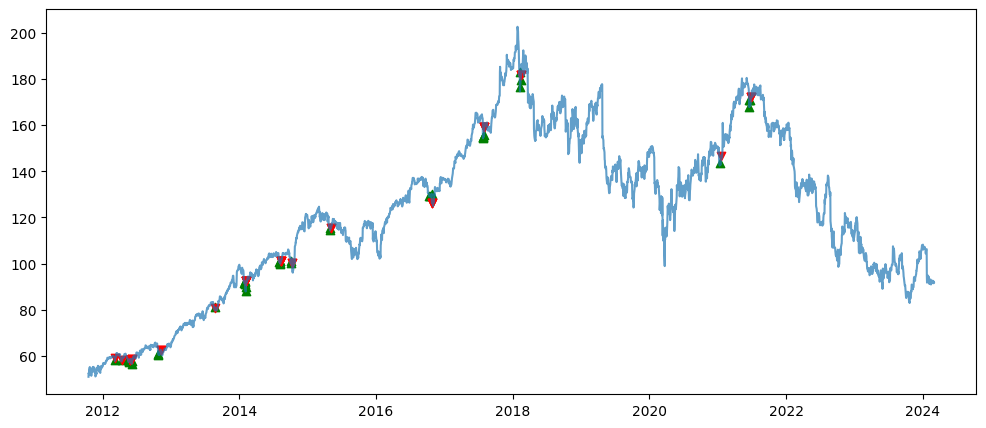

In [38]:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[buy].index, frame.loc[buy]['Adj Close'], marker='^', c='g')
plt.scatter(frame.loc[sell].index, frame.loc[sell]['Adj Close'], marker='v', c='r')

plt.plot(frame['Adj Close'], alpha=0.7)

In [42]:
profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values)/ frame.loc[buy].Open.values
profits

array([ 0.01841858,  0.01323802, -0.0115183 , -0.01105814,  0.00212315,
        0.01287556,  0.03632401,  0.02847867,  0.01033357,  0.01558087,
        0.01012236, -0.00346098,  0.00108178, -0.00407378,  0.02345979,
        0.01052883,  0.02759942,  0.00556546,  0.00556546,  0.01286469,
        0.0062834 ,  0.01170129,  0.01861865,  0.01306246,  0.0130085 ,
        0.01320242, -0.00076654,  0.00355307, -0.01841872,  0.01366927,
        0.02033747,  0.01195283,  0.01595001,  0.00852711,  0.02154845,
        0.00861573,  0.01892706, -0.0052846 ,  0.01409035,  0.01120925])

In [43]:
win_rate = [i for i in profits if i > 0]
len(win_rate)/len(profits)

0.825

In [44]:
#Number of trades done:
len(profits)

40

As we can see, 40 trades in 10 years is not much. So, lets consider more stocks.

In [51]:
matrixsignals= [] 
matrixprofits= []

for i in range(15):
    frame=RSIcalc(tickers[i])
    buy, sell = getSignals(frame)
    profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values)/ frame.loc[buy].Open.values
    matrixsignals.append(buy)
    matrixprofits.append(profits)  

[*********************100%%**********************]  1 of 1 completed
C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_28860\1986622364.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['RS'] = dataset['avg_Up']/dataset['avg_Down']
C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_28860\1986622364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['RSI'] = dataset['RS'].apply(lambda x: 100 - (100/(x + 1)))
C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_28860\1986622364.py:12: SettingWithCopyW

In [52]:
allprofit = []
for i in matrixprofits:
    for e in i:
        allprofit.append(e)

wins = [i for i in allprofit if i>0]
len(wins)/len(allprofit)

0.7350877192982456

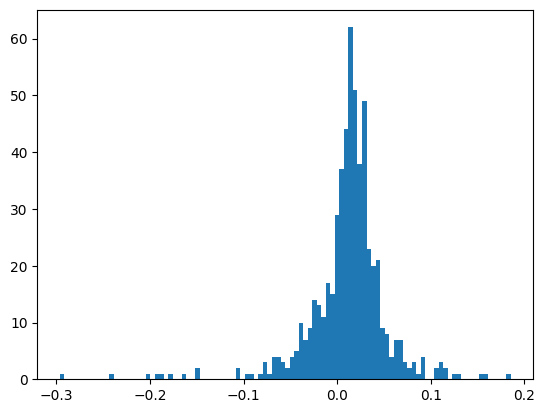

In [53]:
plt.hist(allprofit, bins=100)
plt.show()